# PBR Modelling and Optimization #

This code performs the differential analysis for Methoxy-MethylHeptane(MMH) process carried out in a packed bed reactor (PBR). The reactor optimization is also performed to ensure the various criteria required for the process are met.

The reaction is as follows:
   
    MH + MeOH ↔ MMH
    
    2MeOH → DME + H2O
    
    MH + H2O → MHOH
    
The chemical 2-methoxy-2-methylheptane (MMH) produced from 2-methyl-1-heptene (MH) and
ethanol (MeOH), as shown below. The undesired byproducts are dimethyl ether (DME) and 2-
methyl-2-heptanol (MHOH). Water (H2O) is an intermediate reaction species.

The process chemistry can then be rewritten as
    
    MH + MeOH ↔ MMH

    2MeOH + MH → DME + MHOH




## Mass and Energy Differential Balances  

In [2]:
# Required packages
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# CpdT integrals for reaction 1
# A = MeOH, B = MH, C = MMH, D = DME, E = MHOH

def Cp_integrals_rxn1(T, T_0):
    # Cp Data - Integrals for heat of reactions. All in kJ/kmol/K
    Cp_A = (105800*(T-T_0) - (362.23/2)*(T**2-T_0**2)\
            + (0.9397/3)*(T**3- T_0**3))/1000
    Cp_B =  ((0.0004/3)*(T**3-T_0**3) + (0.3997/2)*(T**2-T_0**2)\
            + 81.72*(T-T_0))
    Cp_C = ((8e-5/3)*(T**3 - T_0**3) + (0.7091/2)*(T**2-T_0**2)\
            + 66.375*(T-T_0))
    
    # Note: Account for stoich coeff.
    return  Cp_C- Cp_A - Cp_B

#CpdT integrals for reaction 2
def Cp_integrals_rxn2(T, T_0):
    # Cp Data - Integrals for heat of reactions. All in kJ/kmol/K
    Cp_A = (105800*(T-T_0) - (362.23/2)*(T**2-T_0**2)\
            + (0.9397/3)*(T**3- T_0**3))/1000
    Cp_B = ((0.0004/3)*(T**3-T_0**3) + (0.3997/2)*(T**2-T_0**2)\
            + 81.72*(T-T_0))
    Cp_D = (134160*(T-T_0) + (447.67/2)*(T-T_0))/1000
    Cp_E = 337.6*(T-T_0)
    
    return -1*(2*Cp_A+Cp_B-Cp_D-Cp_E)

In [4]:
def reaction(x, W):
    # A = MeOH, B = MH, C = MMH, D = DME, E = MHOH, W = catalyst
    
    # All rates are in kmol/s
    F_A0 = float(75)/3600
    F_B0 = float(152)/3600
    
    # Divide the flowrate by the number of tubes
    n_tubes = 156
    F_A0 = F_A0/n_tubes
    F_B0 = F_B0/n_tubes
    F_T0 = F_A0 + F_B0
    
    # x contains the state of the equations
    z1 = x[0]
    z2 = x[1]
    T = x[2]
    
    # Reaction constants
    kf = 6.7e7*math.exp(-90000/(8.314*T))
    kr = 2.1e-6*math.exp(-900/(8.314*T))
    k2 = 1.3e9*math.exp(-105900/(8.314*T))
    
    # Flow rates
    F_A = F_A0 - z1 - 2*z2
    F_B = F_B0 - z1 - z2
    F_C = z1
    F_D = z2
    F_E = z2
    F_T = F_T0 - z1 - z2
    
    # Effectiveness factor
    ef = 0.65
    
    # Rate of reactions
    r1 = ef*kf*((F_A*F_B)/F_T**2) - kr*(F_C/F_T)
    
    r2 = ef*k2*((F_A/F_T)**2)
    
    # Cp Data - All in kJ/kmol/K
    Cp_A = (105800 - 362.23*T + 0.9397*(T**2))/1000
    Cp_B = (0.0004*(T**2) + 0.3997*T + 81.72)
    Cp_C = (8e-5*(T**2) + 0.7091*T + 66.375)
    Cp_D = (134160 + 447.67*T)/1000
    Cp_E = 337.6
    
    
    # Delta H_rxn - All in kJ/kmol
    Hrxn_1 = 36000 + Cp_integrals_rxn1(T, 273)
    Hrxn_2 = -29000  + Cp_integrals_rxn2(T, 273)
    
    # Generated (consumed) heat in kJ/(kgcat*s)
    # Hrxn should be negative for endothermic reactions.
    Qg = r1*(-1)*Hrxn_1 + r2*(-1)*Hrxn_2 
    
    rho_bulk = 800 # kg/m^3
    Ta = 410 # Kelvin, assummed steam temperature.
    U =  100 # W/m^2/K, assumed Ua for Steam, verified by HTRI.
    a =  4/0.06 # Heat exchanger area per unit volume = A/V = 4/D
                # for pipes.
    
    Qr = U*a*(T-Ta)/(rho_bulk*1000) # kJ/kgCat/s
    
    # Differential equations
    dz1dW = r1
    
    dz2dW = r2
    
    dTdW = (Qg - Qr)/(F_A*Cp_A+F_B*Cp_B+F_C*Cp_C+F_D*Cp_D+F_E*Cp_E)
    
    return [dz1dW, dz2dW, dTdW]
    
    
    

In [5]:
# Number of tubes.
n_tubes = 156
# Initial conditions: zheta1 = zheta2 = 0,
# Inlet temperature = 390K.
x0 = [0,0,390]
# Integrate from 0 to cat_per_tube (kg) to determine
# conversion per tube.
total_amt_cat = 8000
cat_per_tube = total_amt_cat/n_tubes
W = np.linspace(0,cat_per_tube,2000)

In [6]:
# Solve the set of differential equations.
x = odeint(reaction, x0, W)

In [7]:
# Get the solved results for each of the independent variables.
zheta1 = x[:,0]
zheta2 = x[:,1]
temperature = x[:,2]

In [8]:
# Flow profiles for each species.
# A = MeOH, B = MH, C = MMH, D = DME, E = MHOH
fa = (75.0/3600/n_tubes - zheta1 -2*zheta2)*3600
fb = (152.0/3600/n_tubes - zheta1 -zheta2)*3600
fc = 3600*zheta1
fd = 3600*zheta2
fe = 3600*zheta2

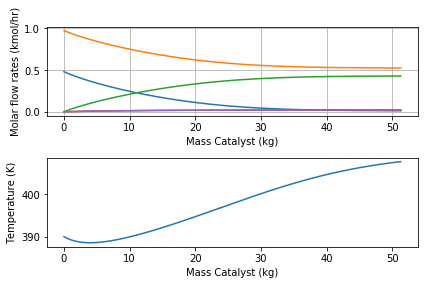

In [9]:
# Plot the flow rate and temperature profiles down the
# length of a tube.
fig, axs = plt.subplots(2,1)
axs[0].plot(W, fa,
            W, fb,
            W, fc,
            W, fd,
            W, fe)
axs[0].set_xlabel('Mass Catalyst (kg)')
axs[0].set_ylabel('Molar flow rates (kmol/hr)')
axs[0].grid(True)

axs[1].plot(W, temperature)
axs[1].set_xlabel('Mass Catalyst (kg)')
axs[1].set_ylabel('Temperature (K)')

fig.tight_layout()
plt.show()

In [10]:
# MMH Yield
print("MMH Yield: {}%".format(round(fc[-1]/fa[0]*100, 1)))

MMH Yield: 89.3%


## Reactor Optimization ##

### Determining if dispersion can be ignored ###

Dispersion can be ignored if the Peclet number is greater than 500.

In [11]:
def calcPeclet(D,m, rho_fluid):
    # D = diameter of tube
    # m = mass flow rate in kg/s PER TUBE
    
    # Superficial velocity
    U = (4*m)/(math.pi*rho_fluid*D**2)
    dp = 850e-6
    # Effective diffusivity in m^2/s
    # Value from literature scaled up to reactor exit temperature.
    De = 2.47e-9 *(410.0/367)
    Pe = (U*dp)/De
    
    return Pe

### Reynolds number ###

In [12]:
def calcRe(D,m, rho_fluid, viscosity_fluid):
    # D = diameter of tube
    # m = mass flow rate in kg/s PER TUBE
    
    # Superficial velocity
    U = (4*m)/(math.pi*rho_fluid*D**2)
    
    porosity = 0.32
    dp = 850e-6 # meters
    Re = D*U*rho_fluid/(viscosity_fluid*(1-porosity))
    
    return Re

### Tallmadge Equation - Calculating Pressure Drop ###

In [13]:
def tallmadge_equation(D,m, rho_fluid, viscosity_fluid, L):
    # D = diameter of tube
    # m = mass flow rate in kg/s PER TUBE
    
    porosity = 0.32
    
    # Superficial velocity
    U = (4*m)/(math.pi*rho_fluid*D**2)
    dp = float(850e-6)
    Re = calcRe(D,m,rho_fluid,viscosity_fluid)

    P_per_L = ((150/Re)+ (4.2/(Re**(1/6))))\
               *((1-porosity)/((porosity)**3))\
               *(U**2/dp)
            
    # Pressure drop in Pascals
    return P_per_L*L 

### Reactor Optimization ###

To peform the optimization, various combinations of tube diameter and length are used to compute the number of tubes required for fixed total volume (based on the amount of catalyst required for the reaction).
For each diameter and length combination the following are computed:
- Peclet number
- Reynolds number
- Pressure drop
- Residence time
- Reactor surface area

In [14]:
def optimize_number_of_tubes(m_total, rho_fluid, viscosity_fluid, V_total):
    
    results = []
    
    # Go from 10cm to 700m of tube length.
    for i in range(1,7000,5):
        L = float(i)/10 # Length of tube in meters
        
        # Go from 20mm to 10cm in tube diamter. 
        for j in range(20,100,5):
            D = float(j)/1000 # Diameter in meters
            V_tube = (math.pi/4)*(D**2)*L
            n_tubes = V_total/V_tube
            
            # Mass per tube
            m_tube = float(m_total)/n_tubes
            # Peclet number
            Pe = calcPeclet(D,m_tube,rho_fluid)
            # Reynolds number
            Re = calcRe(D, m_tube, rho_fluid, viscosity_fluid)
            # Pressure drop
            deltaP = tallmadge_equation(D, m_tube, rho_fluid, viscosity_fluid, L)
            # Residence time
            residence_time = V_tube/(m_tube/rho_fluid)
            # Reactor surface area
            reactor_SA = n_tubes*math.pi*D*L
            
            results.append((round(n_tubes), round(Pe,-2), round(Re,-1), round(deltaP,-1), D, L, round(residence_time,-2), round(reactor_SA,-1) ))
            
    return results
            

In [15]:
# Type in the actual parameters of the system.
# Arg0: Mass flowrate (kg/s)
# Arg1: Density (kg/m^3)
# Arg2: Viscosity (Pa*s)
# Arg3: Volume of reactor (m^3)
results = optimize_number_of_tubes(
    19310.0/3600, 660.0, 0.2e-3, 10)

In [16]:
optimzed_results = pd.DataFrame(
    results,columns=["Number of Tubes", "Peclet Number",
                     "Reynolds Number", "Pressure Drop (Pa)",
                     "Diameter of tube (m)","Length of tube (m)",
                     "Residence Time in tube (s)",
                     "Reactor SA (m^2)"])

In [17]:
# Number of cases analyzed.
len(optimzed_results)

22400

In [18]:
optimzed_results.loc[
    (optimzed_results["Pressure Drop (Pa)"] < 101000) \
     & (optimzed_results["Peclet Number"] > 500) \
     & (optimzed_results["Reynolds Number"] > 3500)\
     & (optimzed_results["Length of tube (m)"] < 24)\
     & (optimzed_results["Number of Tubes"] > 10)\
     & (optimzed_results["Reactor SA (m^2)"] < 1000)\
     & (optimzed_results["Diameter of tube (m)"] < 0.065)\
     & (optimzed_results["Number of Tubes"] < 170),
     :].head()

,Number of Tubes,Peclet Number,Reynolds Number,Pressure Drop (Pa),Diameter of tube (m),Length of tube (m),Residence Time in tube (s),Reactor SA (m^2)
680,168,5300.0,4990.0,160.0,0.06,21.1,1200.0,670.0
696,164,5400.0,5110.0,170.0,0.06,21.6,1200.0,670.0
712,160,5500.0,5230.0,180.0,0.06,22.1,1200.0,670.0
728,156,5700.0,5350.0,190.0,0.06,22.6,1200.0,670.0
744,153,5800.0,5470.0,200.0,0.06,23.1,1200.0,670.0


#### Write data to csv ####

In [19]:
data = pd.DataFrame({'Catalyst': W,'MeOH': fa, 'MH': fb, 'MMH': fc,
                     'DME': fd, 'MHOH':fe, 'Temperature': temperature})

In [20]:
data.head()

,Catalyst,MeOH,MH,MMH,DME,MHOH,Temperature
0,0.000000,0.480769,0.974359,0.000000,0.000000,0.000000,390.000000
1,0.025654,0.479875,0.973520,0.000783,0.000056,0.000056,389.976961
2,0.051308,0.478983,0.972684,0.001564,0.000111,0.000111,389.954187
3,0.076962,0.478094,0.971850,0.002343,0.000166,0.000166,389.931675
4,0.102615,0.477209,0.971020,0.003118,0.000221,0.000221,389.909422
